# Imports

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Read the image in grayscale and extract its key points

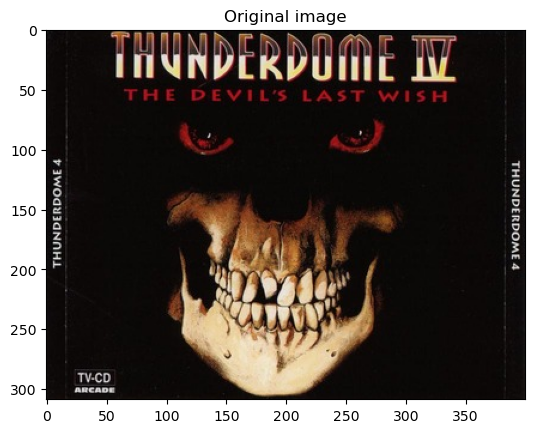

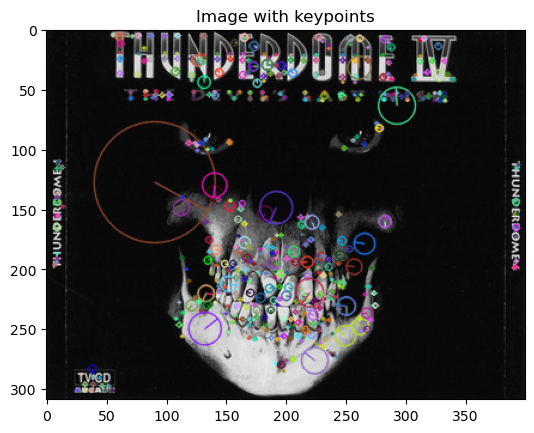

In [3]:
parent_path = './resources'
img_path = 'thunderdome.jpg'
img = cv.imread(f'{parent_path}/{img_path}')
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create()
img_kp, img_des = sift.detectAndCompute(img_gray, None)
img_with_kp = cv.drawKeypoints(img_gray, img_kp, img.copy(), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure()
plt.title('Original image')
plt.imshow(img_rgb, cmap=plt.cm.jet)
plt.figure()
plt.title('Image with keypoints')
plt.imshow(img_with_kp, cmap=plt.cm.jet)


# Modify the image and match keypoints.

## Add random noise

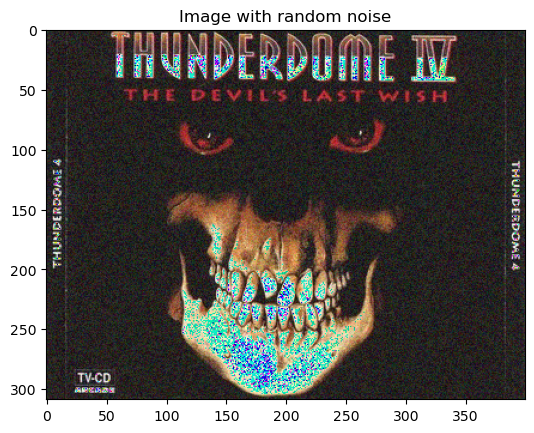

In [4]:
n, m, c = img.shape
noise = (np.random.rand(n, m, c) * 255).astype('uint8')
beta = 0.2
noisy_image = (img + beta * noise).astype('uint8')
noisy_image = ((noisy_image - noisy_image.min()) * (1/(noisy_image.max() - noisy_image.min()) * 255)).astype('uint8')
plt.title('Image with random noise')
plt.imshow(cv.cvtColor(noisy_image, cv.COLOR_BGR2RGB), cmap=plt.cm.jet)

## Apply an afine transformation to the previous noisy image

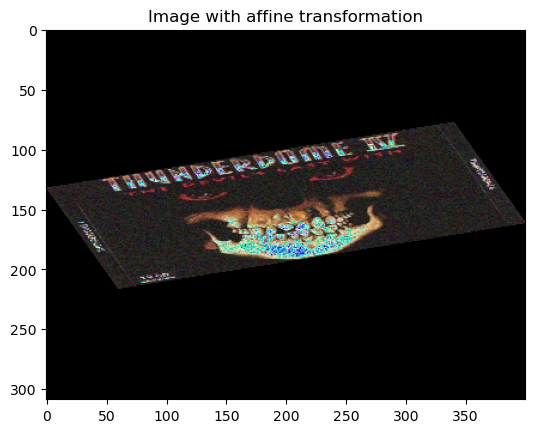

In [5]:
src = np.array([[0, 0], [noisy_image.shape[1] - 1, 0], [0, noisy_image.shape[0] - 1]]).astype(np.float32)
dst = np.array(
    [[0, noisy_image.shape[1]*0.33],
     [noisy_image.shape[1]*0.85, noisy_image.shape[0]*0.25],
     [noisy_image.shape[1]*0.15, noisy_image.shape[0]*0.7]
    ]).astype(np.float32)
warp_matrix = cv.getAffineTransform(src, dst)
img_noise_affine = cv.warpAffine(noisy_image, warp_matrix, (noisy_image.shape[1], noisy_image.shape[0]))
plt.title('Image with affine transformation')
plt.imshow(cv.cvtColor(img_noise_affine, cv.COLOR_BGR2RGB), cmap=plt.cm.jet)

## Match image descriptors

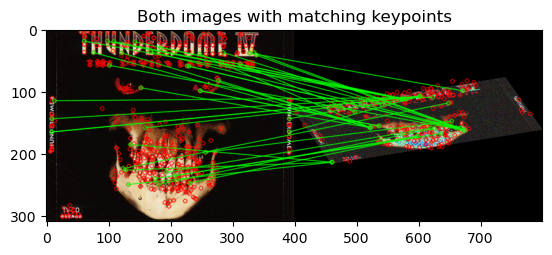

In [6]:
img_noise_affine_gray = img_gray = cv.cvtColor(img_noise_affine, cv.COLOR_BGR2GRAY)
img_noise_affine_kp, img_noise_affine_des = sift.detectAndCompute(img_noise_affine, None)
img_noise_affine_with_kp = cv.drawKeypoints(
    img_noise_affine_gray,
    img_noise_affine_kp,
    img_noise_affine.copy(),
    flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(img_des, img_noise_affine_des, k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
distance_threshold = 0.8
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < distance_threshold * n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (0,0,255),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)
matching_image = cv.drawMatchesKnn(img, img_kp, img_noise_affine, img_noise_affine_kp, matches, None, **draw_params)
plt.title('Both images with matching keypoints')
plt.imshow(cv.cvtColor(matching_image, cv.COLOR_BGR2RGB), cmap=plt.cm.jet)

In [19]:
mistery_des_1 = img_des[0]
orb = cv.ORB_create()
kp = orb.detect(img_gray, None)
kp, des = orb.compute(img_gray, kp)
mistery_des_2 = des[0]

# Which is the SIFT descriptor? 👀

In [43]:
size_1 = mistery_des_1.itemsize * len(mistery_des_1)
size_2 = mistery_des_2.itemsize * len(mistery_des_2)
print(f'Mistery descriptor 1: {mistery_des_1}.\n Length: {mistery_des_1.itemsize} bytes * '
      f'{len(mistery_des_1)} elements = {size_1} bytes.')
print(f'\n\n\nMistery descriptor 2: {mistery_des_2}.\n Length: {mistery_des_2.itemsize} byte * '
      f'{len(mistery_des_2)} elements = {size_2} bytes.')
print(f'\n\n\nDescriptor 1 is {int(size_1 / size_2)} times bigger than descriptor 2! 😳😳😳🤔')

Mistery descriptor 1: [  4.   2.   2.   1.   0.   0.   5.  13.   2.   4.   2.   0.   0.  11.
  62.  19.   0.   6.   5.   0.   0.  22.  32.   0.   0.   3.   8.   0.
   0.   3.   3.   0.  63.  22.   0.   0.   0.   0.   5.  30. 126.  38.
   0.   4.   1.  39. 126.  80.   9.   2.   5.  25.  16. 126. 126.   7.
   1.   1.   2.   2.   4.  96.  83.   2.  78.  18.   0.   0.   0.   0.
   0.  20. 126.  42.   2.  62.  24.   4.   6.  61.  71.  15.  40. 126.
  56.  38.  17.  25.  67.   7.   9.   7.  36. 100.  70.  59.  60.  20.
   1.   0.   0.   1.   3.  10.  99.  65.  55.  84.  25.   0.   0.  18.
 126.  23.  18.  94.  39.   0.   0.  36.  95.  25.  50.  58.  15.  18.
   4.  38.].
 Length: 4 bytes * 128 elements = 512 bytes.



Mistery descriptor 2: [ 70 172 130  94 137 144  14 239 190 146 224 145 224 227 100 215  73 102
 107 140 120  79 203 104 185 242 222  25 144 116 170 138].
 Length: 1 byte * 32 elements = 32 bytes.



Descriptor 1 is 16 times bigger than descriptor 2! 😳😳😳🤔
